In [1]:
# plotting adult data analysis 

In [3]:
import pandas as pd 
import scanpy as sc
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import seaborn as sns
sns.set_style({'axes.grid' : False})

scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
import numpy as np
from matplotlib import colors as mcolors

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

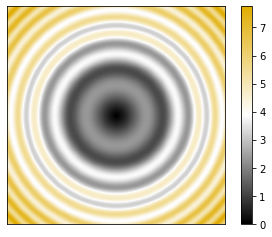

In [5]:
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ['#000000','#FFFFFF','#E1AD01']

fig, ax = plt.subplots(1,1)
im = ax.imshow(z, cmap=get_continuous_cmap(hex_list))
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks

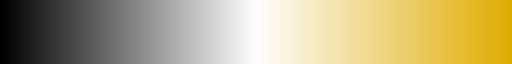

In [118]:
c_colors = get_continuous_cmap(list((hex_list)))
c_colors

In [ ]:
fname = 'adultThyrocytes_6datasets_LRv1.fThy.full.csv'
output = pd.read_csv(f'../data/{fname}', index_col='Unnamed: 0').set_index('cellID', drop=True)
output.head(3)

,annot,LRv1_fThyfull_fTFC1,LRv1_fThyfull_fTFC2,LRv1_fThyfull_diff,dataset,UMAP_1,UMAP_2,score,cell_assignment,scanpy_cellID,NKX2.1,HHEX,FOXE1,PAX8,GLIS3,TSHR
cellID,,,,,,,,,,,,,,,,
AAACCCATCAGGACAG-1_4,aThy_thyrocytes,3.095302,-3.544944,6.640246,aThy_Wang22,-0.993648,6.839187,5.0000,TFC1,AAACCCATCAGGACAG-1,0.654784,0.654784,1.149843,2.385432,0.480254,1.149843
AAACCCATCGTAACAC-1_4,aThy_thyrocytes,2.076382,-2.348318,4.424700,aThy_Wang22,2.329030,8.196151,4.4247,TFC1,AAACCCATCGTAACAC-1,0.898589,1.534787,1.534787,2.834241,0.547003,1.364117
AAAGAACAGCACTCTA-1_4,aThy_thyrocytes,2.631920,-3.121131,5.753051,aThy_Wang22,-2.279683,7.847005,5.0000,TFC1,AAAGAACAGCACTCTA-1,1.509739,1.459824,1.016235,1.646076,0.507444,1.509739


In [8]:
datasets = output['dataset'].unique()
print(datasets)

['aThy_Wang22' 'aThy_Pu21' 'aThy_Hong23' 'aThy_Mosteiro23' 'aThy_Lu23'
 'aThy_Han20']


In [9]:
# remove Han20 as it is not good quality dataset (no healthy cells)
output = output[output['dataset'].isin(['aThy_Wang22','aThy_Pu21','aThy_Hong23','aThy_Mosteiro23','aThy_Lu23'])]
datasets = output['dataset'].unique()
print(datasets)

['aThy_Wang22' 'aThy_Pu21' 'aThy_Hong23' 'aThy_Mosteiro23' 'aThy_Lu23']


In [44]:
titles = {'Lu_adata' : 'Lu et al. 2023',
          'Ho_adata' : 'Hong et al. 2023',
          'Pu_adata' : 'Pu et al. 2021',
          'Wa_adata' : 'Wang et al. 2022',
          'Mo_adata' : 'Mosteiro et al. 2023',
          'Ha_adata' : 'Han et al. 2020'}

figsize = (10.5, 1.5)


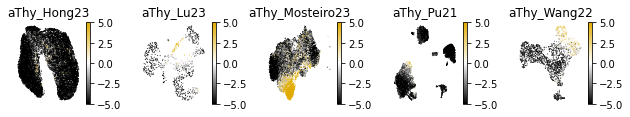

In [124]:
groups = output.groupby('dataset')
ncols = len(groups)
nrows = 1
figsize = 1.5
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
print(f'figsize = {(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize)}')
plt.subplots_adjust(wspace=wspace)
s = 3
# axes = len(adatas.keys())
# fig, axs = plt.subplots(1,axes, figsize=(15,2.5),constrained_layout=True, subplot_kw=dict(aspect='equal'))

for g, ax in zip(groups, axs):
    title = g[0]
    dat   = g[1]
    dat['score'] = dat['score'] * -1
    #dat   = g[1].sort_values(by='score', ascending=False) 

#     g = sns.scatterplot(data=dat, x='UMAP_1', y='UMAP_2', hue='score', s=2, alpha=0.9, palette=c_colors, ax=ax, legend=False)
    g = sns.scatterplot(data=dat, x='UMAP_1', y='UMAP_2', hue='score', s=1, alpha=0.9, palette=c_colors, ax=ax, legend=False, linewidth=0)
    ax.set_title(title)
    ax.set_axis_off()
    
    # Add colorbar
    norm = plt.Normalize(dat["score"].min(), dat["score"].max())
    sm = plt.cm.ScalarMappable(cmap=c_colors, norm=norm)
    cc = plt.colorbar(sm, ax=ax, pad=0.05)

# plt.show()
plt.savefig('./figures/combined_score_mi.pdf')    

## calc percentage

In [95]:
output_num = output.groupby('dataset')['cell_assignment'].agg('value_counts').reset_index().pivot(index='cell_assignment', columns='dataset', values='count')
output_num

dataset,aThy_Hong23,aThy_Lu23,aThy_Mosteiro23,aThy_Pu21,aThy_Wang22
cell_assignment,,,,,
TFC1,18546,632,12330,5730,1249
TFC2,93,42,2254,32,178
ambiguous,492,80,2614,262,219


In [96]:
output_num.sum()

dataset
aThy_Hong23        19131
aThy_Lu23            754
aThy_Mosteiro23    17198
aThy_Pu21           6024
aThy_Wang22         1646
dtype: int64

In [97]:
# get percent 
dic = '{:.2f}'
df_percent = output_num / output_num.sum() * 100
print(f"TFC1 %: {dic.format(df_percent.loc['TFC1'].min())}% - {dic.format(df_percent.loc['TFC1'].max())}%")
print(f"TFC2 %: {dic.format(df_percent.loc['TFC2'].min())}% - {dic.format(df_percent.loc['TFC2'].max())}%")

TFC1 %: 71.69% - 96.94%
TFC2 %: 0.49% - 13.11%


## make stats

In [98]:
# load fetal single cell data
adata = sc.read('/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/THY2023_Jun_2n/soupX_2n/Thyrocytes/workingObj/cdata_thy_noStressEmb.h5ad')
fetal_df = sf.summaryTable(adata,['celltype','donor'], return_df=True)
fetal_df[fetal_df['celltype'] == 'thy_Lumen-forming']

[INFO] - total cells: 50597


,celltype,donor,cells
12,thy_Lumen-forming,Hrv194,1057
17,thy_Lumen-forming,Hrv202,917
20,thy_Lumen-forming,Hrv197,827
22,thy_Lumen-forming,Hrv218,796
23,thy_Lumen-forming,Hrv214,791
24,thy_Lumen-forming,Hrv196,748
27,thy_Lumen-forming,Hrv199,677
28,thy_Lumen-forming,Hrv203,640
29,thy_Lumen-forming,Hrv188,601
30,thy_Lumen-forming,Srv10,598


In [99]:
adata.obs['celltype'].value_counts()

celltype
thy_TH_processing    28998
thy_Lumen-forming    11720
thy_Cycling           9879
Name: count, dtype: int64

In [100]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [101]:
fTFC2_num = fetal_df.loc[fetal_df['celltype'] == 'thy_Lumen-forming', 'cells'].values.tolist()
f_sum = fetal_df.groupby('donor')['cells'].sum().values.tolist()

aTFC2_num = output_num.loc['TFC2'].values.tolist()
a_sum = output_num.sum().values.tolist()

# Count successes and total observations
# count = [group_a.sum(), group_b.sum()]  # [5, 8]
# nobs = [len(group_a), len(group_b)]     # [10, 10]

count = [np.sum(fTFC2_num), np.sum(aTFC2_num)]
nobs = [np.sum(f_sum), np.sum(a_sum)]

# Run z-test
stat, pval = proportions_ztest(count, nobs)
print(f"Z-statistic: {stat:.3f}, p-value: {pval:.3f}")


Z-statistic: 74.869, p-value: 0.000


In [102]:
pval < 1e-4

True

## make barplots

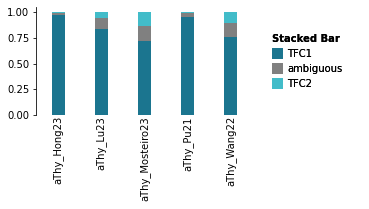

In [31]:
import marsilea as ma
import marsilea.plotter as mp

colors = {'TFC1': '#1B758F',
          'TFC2': '#42BCC9',
          'ambiguous': 'grey'}
df2plot = output_num.loc[['TFC1','ambiguous','TFC2']] #reorder rows
bar = mp.StackBar(df2plot / df2plot.sum(), width=0.3, legend_kws=dict(title="Stacked Bar"), colors=colors)
wb = ma.WhiteBoard(width=3, height=1.5, margin=0.05)
sample_name = mp.Labels(df2plot.columns)
wb.add_layer(bar)
wb.add_legends()
wb.add_bottom(sample_name)
wb.render()
plt.savefig('./figures/barplots_mi.pdf')    

In [125]:
# read adult data 
Ho_adata = sc.read('../workingObj/Hong_2023_cThy.h5ad')
Pu_adata = sc.read('../workingObj/Pu_2021_cThy.h5ad')
Wa_adata = sc.read('../workingObj/Wang_2022_cThy.h5ad')
Lu_adata = sc.read('../workingObj/Lu_2023_cThy.h5ad')
Mo_adata = sc.read('../workingObj/Mosteiro_2023_cThy.h5ad')
Ha_adata = sc.read('../workingObj/Han_2020_cThy.h5ad') #this is bad dataset and not used in the analysis. Thyrocytes don't express TG TPO PAX8 as other datasets

In [126]:
adatas = {
            #'Th_adata' : Th_adata,
          'Ho_adata' : Ho_adata,
          'Pu_adata' : Pu_adata,
          'Wa_adata' : Wa_adata,
          'Lu_adata' : Lu_adata,
          'Mo_adata' : Mo_adata,
#           'Ha_adata' : Ha_adata,
}
len(adatas)

5

In [127]:
output['dataset'].unique()

array(['aThy_Wang22', 'aThy_Pu21', 'aThy_Hong23', 'aThy_Mosteiro23',
       'aThy_Lu23'], dtype=object)

In [128]:
adatas = {
          'aThy_Hong23'     : Ho_adata,
          'aThy_Pu21'       : Pu_adata,
          'aThy_Wang22'     : Wa_adata,
          'aThy_Lu23'       : Lu_adata,
          'aThy_Mosteiro23' : Mo_adata,
#           'aThy_Han20'      : Ha_adata,
}

len(adatas)

5

aThy_Hong23	-- len mi's file 19131 	| len adata 19131 	| len intersect 19131 	| ratio from mi' 1.0
aThy_Pu21	-- len mi's file 6024 	| len adata 6024 	| len intersect 6024 	| ratio from mi' 1.0
aThy_Wang22	-- len mi's file 1646 	| len adata 1646 	| len intersect 1646 	| ratio from mi' 1.0
aThy_Lu23	-- len mi's file 754 	| len adata 754 	| len intersect 754 	| ratio from mi' 1.0
aThy_Mosteiro23	-- len mi's file 17198 	| len adata 17792 	| len intersect 17198 	| ratio from mi' 1.0


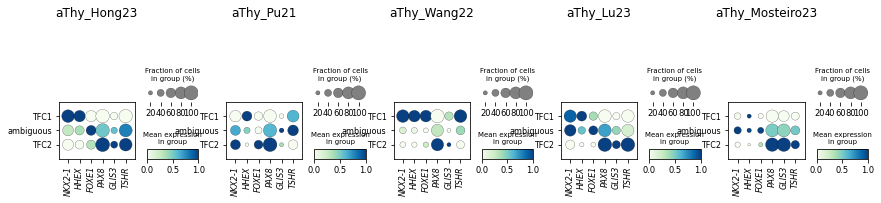

In [142]:
groups = output.groupby('dataset')
ncols = len(groups)
nrows = 1
figsize = 2.5
wspace = 0.2
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
gg = ['NKX2-1','HHEX','FOXE1','PAX8','GLIS3','TSHR']
for k, ax in zip(adatas.keys(), axs):
    output_sub  = output[output['dataset'] == k].set_index('scanpy_cellID')
    intersect = list(set(adatas[k].obs.index) & set(output_sub.index))
    print(f"{k}\t-- len mi's file {output_sub.shape[0]} \t| len adata {adatas[k].shape[0]} \t| len intersect {len(intersect)} \t| ratio from mi' {len(intersect)/output_sub.shape[0]}")
    adata_subset = adatas[k][intersect]
    adata_subset.obs = pd.concat([adata_subset.obs, output_sub.loc[intersect, 'cell_assignment']], axis=1)
    
    AXS = sc.pl.dotplot(adata_subset, cmap='GnBu', groupby='cell_assignment', var_names=gg,
                        standard_scale='var', title=k, ax=ax, show=False, use_raw=False,
                        categories_order=['TFC1','ambiguous','TFC2'], dot_max=1)
    for l in AXS['mainplot_ax'].get_xticklabels():
        l.set_style('italic')
        l.set_fontsize(8)
    for l in AXS['mainplot_ax'].get_yticklabels():
        l.set_fontsize(8)
    AXS['size_legend_ax'].title.set_fontsize(7)
    AXS['color_legend_ax'].title.set_fontsize(7)
plt.savefig('./figures/dotplots_mi.pdf')    

### plot PAX8

In [130]:
adatas.keys()

dict_keys(['aThy_Hong23', 'aThy_Pu21', 'aThy_Wang22', 'aThy_Lu23', 'aThy_Mosteiro23'])

In [131]:
adatas_norm = {}
for k, v in adatas.items():
    adatas[k].X = adatas[k].layers['counts'].copy()
    sc.pp.normalize_total(adatas[k], target_sum=1e4)
    sc.pp.log1p(adatas[k])
    adatas_norm[k] = adatas[k]

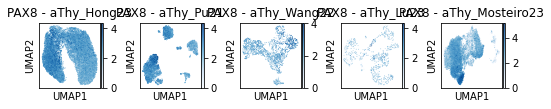

In [134]:
ncols = len(adatas_norm.keys())
nrows = 1
figsize = 1.2
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
s = 3
alpha = 0.8
# axes = len(adatas.keys())
# fig, axs = plt.subplots(1,axes, figsize=(15,2.5),constrained_layout=True, subplot_kw=dict(aspect='equal'))
for k, ax in zip(adatas_norm.keys(), axs):
    AXS = sc.pl.umap(adatas_norm[k], color=["PAX8"],legend_fontsize='large',ax=ax, show=False, s=s, cmap='Blues', title=f'PAX8 - {k}', alpha=alpha)
#     for l in AXS['mainplot_ax'].get_xticklabels():
#         l.set_fontsize(8)
#     for l in AXS['mainplot_ax'].get_yticklabels():
#         l.set_fontsize(8)
plt.savefig('./figures/PAX8_mi.pdf') 